In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9985042018943277700
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12655565543386197559
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8422918663797743693
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648777152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17208784869352758789
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:
import pandas as pd
import numpy as np

import os.path
import pickle
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.normalization import BatchNormalization

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Input, Embedding
from keras.layers.merge import Concatenate

import matplotlib.pyplot as plt
import nltk
import re

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

from numpy import array
from numpy import asarray
from numpy import zeros

Using TensorFlow backend.


In [0]:
real = pd.read_csv('/content/gdrive/My Drive/twitter misinfo/2020_04_10000_real_tweets.csv', header = None)
fake = pd.read_csv('/content/gdrive/My Drive/twitter misinfo/2020_04_10000_fake_tweets_unconditional.csv', header = None)


In [0]:
real.columns = ['tweet']

In [0]:
real['index'] = real.index

In [0]:
fake.columns = ['tweet']
fake['index'] = fake.index

In [0]:
cols = real.columns.tolist()
cols = cols[-1:] + cols[:-1]

In [0]:
real = real[cols]

In [0]:
cols = fake.columns.tolist()
cols = cols[-1:] + cols[:-1]
fake = fake[cols]

In [0]:
real['label'] = 1
fake['label'] = 0
real.head()

,index,tweet,label
0,0,#Taiwan isn't a member of the #WHO. Taiwan tr...,1
1,1,From the DJs to the CJs.. Look whose in the PJ...,1
2,2,The @ClinicalBioinfo led by @xdopazo releases ...,1
3,3,IMF expects #Greece to be the worst hit econom...,1
4,4,More on #COVID19 - China witnessed a slight in...,1


In [0]:
fake.head()

,index,tweet,label
0,0,@chrislhayes I think it's important to note th...,0
1,1,"The problem is, it's the Chinese that are bein...",0
2,2,Do you know of any people who are looking for ...,0
3,3,Just as the COVID-19 pandemic has shown that t...,0
4,4,Covid-19's impact on the economy: The RBC Stat...,0


In [0]:
combined = pd.concat([fake, real])
features = combined['tweet']
labels = combined['label']
combined = combined.sample(frac = 1).reset_index(drop = True)
combined['index'] = combined.index
combined.tail()

,index,tweet,label
19992,19992,*Hears about a deadly virus going around* *Fin...,1
19993,19993,The mother of Manchester City manager Pep Guar...,1
19994,19994,#COVID19 Updates 👇,0
19995,19995,Each penny counts. Contribute whatever you can...,1
19996,19996,Great work @DJLuzo. We are more than ever pro...,0


In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# combined['tweet'] = [entry.lower() for entry in combined['tweet']]
combined['tweet_lower'] = combined['tweet'].astype(str).str.replace('[^a-zA-Z]',' ').str.lower()
combined.head()

,index,tweet,label,tweet_lower
0,0,The reported #COVID19 cases in the #Indian cap...,0,the reported covid cases in the indian cap...
1,1,"#COVID19 ""When you are ready, let's be ready....",0,covid when you are ready let s be ready ...
2,2,#AskATeeSood #COVID19 #WednesdayThoughts,0,askateesood covid wednesdaythoughts
3,3,Corporate greed blocked manufacture of inexpen...,1,corporate greed blocked manufacture of inexpen...
4,4,Retweet if you are able to get the photos that...,0,retweet if you are able to get the photos that...


In [0]:
stop_re = '\\b'+'\\b|\\b'.join(nltk.corpus.stopwords.words('english'))+'\\b'
combined['tweet_stop'] = combined['tweet_lower'].astype(str).str.replace(stop_re, '')

In [0]:
combined['tweet_stop'].head(10)

0     reported  covid   cases    indian capital   t...
1     covid        ready  let   ready      coronavi...
2             askateesood   covid    wednesdaythoughts
3    corporate greed blocked manufacture  inexpensi...
4            retweet    able  get  photos  look like  
5     people   realize        twitter  amp  faceboo...
6     covid       new cases confirmed      patients...
7    today   covid   day  tablighijamaat  tablighii...
8        covid doctors   per request     original e...
9       told     fair   pms must   place  corona   ...
Name: tweet_stop, dtype: object

In [0]:
combined['tweet_final'] = combined['tweet_stop'].astype(str).str.split()

In [0]:
x = []
sentences = list(combined["tweet_final"])
for line in combined['tweet_final']:
    x.append(line)

y = labels

In [0]:
y

0       0
1       0
2       0
3       0
4       0
       ..
9995    1
9996    1
9997    1
9998    1
9999    1
Name: label, Length: 19997, dtype: int64

In [0]:
# final_tweet_text = []
# for entry in tqdm(combined['tweet_lower']):
#         # Declaring Empty List to store the words that follow the rules for this step
#         Final_words = []
#         # Initializing WordNetLemmatizer()
#         word_Lemmatized = WordNetLemmatizer()
#         # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
#         for word, tag in pos_tag(entry):
#             # Below condition is to check for Stop words and consider only alphabets
#             if word not in stopwords.words('english') and word.isalpha():
#                 word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
#                 Final_words.append(word_Final)
#         final_comment_text.append(Final_words)
#     # The final processed set of words for each iteration will be stored in 'text_final'
#     combined['tweet_final'] = final_comment_text
#     combined.to_pickle("final_pickle_unc.pkl")
# combined.head()

In [0]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [0]:
embeddings_dictionary = dict()

glove_file = open('/content/gdrive/My Drive/twitter misinfo/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [0]:
# deep_inputs = Input(shape=(maxlen,))
# embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
# LSTM_Layer_1 = LSTM(128)(embedding_layer)
# dense_layer_1 = Dense(1, activation='sigmoid')(LSTM_Layer_1)
# model = Model(inputs=deep_inputs, outputs=dense_layer_1)

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
# embed_dim = 50
# lstm_out = 64
# batch_size = 32
# max_words = 5000
# model = Sequential()
# model.add(Embedding(max_words, embed_dim, input_length = maxlen))
# model.add(LSTM(lstm_out))
# model.add(Dense(256))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, name='out_layer'))
# model.add(Activation('sigmoid'))
# model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
# print(model.summary())

In [0]:
embed_dim = 100
lstm_out = 64
batch_size = 128
max_words = 5000
model = Sequential()
model.add(Embedding(max_words, embed_dim, input_length = maxlen))
model.add(LSTM(lstm_out))
model.add(Dense(256))
model.add(Activation('sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, name='out_layer'))
model.add(Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          500000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                

In [0]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=5, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10717 samples, validate on 2680 samples
Epoch 1/5
10717/10717 [==============================] - 32s 3ms/step - loss: 0.6935 - acc: 0.4978 - val_loss: 0.7287 - val_acc: 0.5067
Epoch 2/5
10717/10717 [==============================] - 29s 3ms/step - loss: 0.6933 - acc: 0.4980 - val_loss: 0.7030 - val_acc: 0.5067
Epoch 3/5
10717/10717 [==============================] - 29s 3ms/step - loss: 0.6933 - acc: 0.4987 - val_loss: 0.6955 - val_acc: 0.5067
Epoch 4/5
10717/10717 [==============================] - 29s 3ms/step - loss: 0.6934 - acc: 0.5003 - val_loss: 0.6934 - val_acc: 0.5067
Epoch 5/5
10717/10717 [==============================] - 29s 3ms/step - loss: 0.6936 - acc: 0.4964 - val_loss: 0.6931 - val_acc: 0.5067


In [0]:
# pickle.dump(history, open('lstm_model_unc.sav', 'wb'))

In [0]:
score = model.evaluate(x_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print(score)

6600/6600 [==============================] - 6s 936us/step
Test Score: 0.6933950088963364
Test Accuracy: 0.49742424488067627
[0.6933950088963364, 0.49742424488067627]


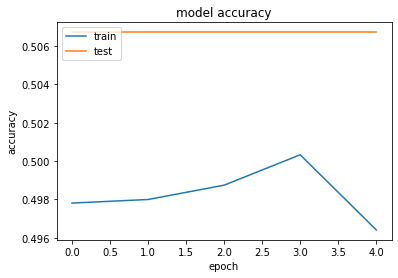

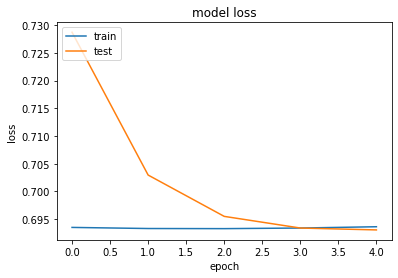

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()